![Predicting Airline Delays for Airbnb](images/airbnb_title.png)

<i> <b>Disclaimer:</b> I don't work for Airbnb - the data challenge was to create a flight delay predictor model based on Department of Transportation data; I just added the Airbnb aspect for fun.</i>

# Introduction

The general aim of this project was to build a classification model for predicting domestic flight arrival delays. I decided to narrow down that aim to a more specific ojective in order to guide my progress and make it easier to assess success.

The ultimate goal I settled on was to create a dual-model tool to help employees at Airbnb book on-time flights between offices, and to monitor their likelihood of delay on the day of travel. Given these aims, I decided that a four-level risk forecast for delays would be more valuable to users than a binary prediction, so I built my models accordingly.

In this write-up, I'll go through my process of defining this goal, developing a set of variables, defining success metrics, and building and evaluating two models. If you want to skip straight to where the R code starts, start with the "Loading the Data" section.

<b>Data Sources:</b> Dept. of Transportation <a href="https://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time">Airline On-Time Performance Data</a>, National Oceanic and Atmospheric Administration <a href="https://www.ncdc.noaa.gov/cdo-web/search">Climate Data Online Search </a>  
<b>Tools used:</b> R, MySQL, Excel Macros


# Goal Definition

### Choosing Cities

I decided to limit my analysis to certain cities, both because of the sheer size of the data files, and because some models can't handle categorical variables with more than a certain number of levels.

One of my favorite startups is Airbnb (I spent almost two years living in Airbnbs around the world as a digital nomad), so I decided to pick the three US cities where Airbnb has major offices. I also added Washington DC, the area I'm from, since I imagine Airbnb executives travel often to the capital for policy discussions and press events.


![city images](images/airbnb_cities.png)

<center><i> <b>Top:</b> Airbnb's major US offices. <b>Bottom:</b> Airbnb CEO Brian Chesky speaks to the State Department in Washington DC in 2016.</i></center>

I used MySQL to pull flights where both the origin and destination were among the seven airports that can be used to access the four cities:

<blockquote><b>
1. Seattle-Tacoma International (SEA) <br>
2. Portland International (PDX)<br>
3. San Francisco International (SFO)<br>
4. Oakland International (OAK)<br>
5. San Jose International (SJC)<br>
6. Dulles International (IAD)<br>
7. Ronald Reagan Washington National (DCA)<br>
</b></blockquote>

![cities map](images/airbnb_map.jpg)

<center><i>The seven airports used in this project.</i></center>

### Two Models

My goal was build something that could actually be useful to Airbnb employees. So when would Airbnb-ers use a flight delay predictor tool and why? Perhaps either when booking flight tickets between offices days/weeks/months in advance, or on the day of travel, to be able to let colleagues know if they were likely to be late for a meeting.

The information available in these two scenerios is quite different, so I decided to build two models:
<blockquote>
   <b>Basic Model:</b> to be used when booking flights, at any point in advance of travel dates.<br><br>

   <b>Day-Of Model:</b> to be checked three hours before a flight's departure, around the time the traveler may be heading to the airport.
   </blockquote>


# Choosing and Creating Variables

### Overview
For both models, my chosen target variable was **ArrDel15**, a binary variable indicating whether a flight's arrival was delayed by 15 minutes or more. Anything less than a 15 minute delay would likely not significantly hamper travel plans.

I used 17 predictor variables for the Basic Model, and an additional 6 for the Day-Of Model (23 total). Outlined below, these variables fall into five categories, indicated by prefixes:
  

![variable codes](images/airbnb_variable_codes.jpg)

<center><i> <b>Note:</b> Calcuated variables were created using R, MySQL and Excel <del>messiness</del>  magic.</i></center>


### Loading the Data
Let's bring in the data for the Basic and Day-Of models, and take a closer look.

In [1]:
suppressWarnings(library(chron))

###Read in data for basic model
basicvars = read.csv('basic.csv')

###Set variable types for those that aren't correctly set automatically
basicvars$XX_MonthAndDay = as.Date(basicvars$XX_MonthAndDay, "%m/%d/%Y")
basicvars$X_DepTimeBlk = chron(times = basicvars$X_DepTimeBlk)
basicvars$X_ArrTimeBlk = chron(times = basicvars$X_ArrTimeBlk)
basicvars$X_DestAirportID = as.factor(basicvars$X_DestAirportID)
basicvars$X_OriginAirportID = as.factor(basicvars$X_OriginAirportID)
basicvars$XX_PeakDate = as.factor(basicvars$XX_PeakDate)
basicvars$X_Month = as.factor(basicvars$X_Month)

In [2]:
dim(basicvars)

[1] 137351     18

In [3]:
head(basicvars)

X_OriginAirportID,X_DestAirportID,X_UniqueCarrier,X_DepTimeBlk,X_ArrTimeBlk,X_CRSElapsedTime,X_Month,X_DayofMonth,X_DayOfWeek,XX_MonthAndDay,XX_Route,XX_PeakDate,XX_OriginAvgArrDel15,XX_DestAvgArrDel15,XX_RouteAvgArrDel15,XX_MonthlyRouteAvgArrDel15,XX_MonthlyRouteAvgArrDelMinutes,Y_ArrDel15
14771,11278,VX,08:00:00,16:00:00,310,10,1,4,1904-10-01,14771 - 11278,0,0.2107,0.1804,0.1709,0.1048,7.0081,1
14747,11278,AS,08:00:00,16:00:00,310,10,1,4,1904-10-01,14747 - 11278,0,0.1629,0.1804,0.1644,0.0484,2.1290,0
14057,11278,AS,09:00:00,17:00:00,304,10,1,4,1904-10-01,14057 - 11278,0,0.1410,0.1804,0.1094,0.0484,1.4032,0
14747,11278,AS,13:00:00,21:00:00,304,10,1,4,1904-10-01,14747 - 11278,0,0.1629,0.1804,0.1644,0.0484,2.1290,0
14771,11278,UA,14:00:00,22:00:00,316,10,1,4,1904-10-01,14771 - 11278,0,0.2107,0.1804,0.1709,0.1048,7.0081,0
14771,11278,VX,08:00:00,16:00:00,305,10,10,6,1904-10-10,14771 - 11278,0,0.2107,0.1804,0.1709,0.1048,7.0081,0


In [4]:
###Read in data for day-of model
dayofvars = read.csv('dayof.csv')

###Set variable types for those that aren't correctly set automatically
dayofvars$XX_MonthAndDay = as.Date(dayofvars$XX_MonthAndDay, "%m/%d/%Y")
dayofvars$X_ArrTimeBlk = chron(times = dayofvars$X_ArrTimeBlk)
dayofvars$X_DepTimeBlk = chron(times = dayofvars$X_DepTimeBlk)
dayofvars$X_DestAirportID = as.factor(dayofvars$X_DestAirportID)
dayofvars$X_OriginAirportID = as.factor(dayofvars$X_OriginAirportID)
dayofvars$XX_PeakDate = as.factor(dayofvars$XX_PeakDate)
dayofvars$X_Month = as.factor(dayofvars$X_Month)


In [5]:
dim(dayofvars)

[1] 137351     24

In [6]:
head(dayofvars)

X_OriginAirportID,X_DestAirportID,X_UniqueCarrier,X_DepTimeBlk,X_ArrTimeBlk,X_CRSElapsedTime,X_Month,X_DayofMonth,X_DayOfWeek,XX_MonthAndDay,...,XX_RouteAvgArrDel15,XX_MonthlyRouteAvgArrDel15,XX_MonthlyRouteAvgArrDelMinutes,XXX_AircraftArrDel_3Before,XXX_ArrDelToday_3Before,W_OriginWindSpeed,W_DestWindSpeed,W_OriginPrecip,W_DestPrecip,Y_ArrDel15
14747,13796,WN,14:00:00,16:00:00,120,11,20,5,1904-11-20,...,0.1905,0.1651,7.9381,1,0.0000000,4.0,2.3,0.0,0.0,0
14747,13796,WN,10:00:00,12:00:00,125,11,27,5,1904-11-27,...,0.1905,0.1651,7.9381,0,0.0000000,3.0,2.9,0.0,0.0,0
13796,14747,WN,13:00:00,15:00:00,120,11,3,2,1904-11-03,...,0.2105,0.1651,9.1394,0,0.1764706,3.5,1.4,0.0,0.8,0
14747,13796,WN,16:00:00,18:00:00,120,11,3,2,1904-11-03,...,0.1905,0.1651,7.9381,0,0.1666667,1.4,3.5,0.8,0.0,0
14747,14831,WN,17:00:00,19:00:00,125,7,30,4,1904-07-30,...,0.1582,0.1571,10.3861,0,0.1428571,3.5,5.9,0.0,0.0,1
14747,13796,WN,15:00:00,17:00:00,125,8,14,5,1904-08-14,...,0.1905,0.2167,11.5635,1,0.0000000,5.2,6.1,30.5,0.0,1


### Data Dictionary
Now, an explanation of the variable names. The most important descriptions to read closely are the XX and XXX variables, as the rest are fairly self-explanatory.

![variables 1](images/vars1.jpg)

![variables 2](images/vars2.jpg)

![variables 3](images/vars3.jpg)

# Assessment and Success Metrics

### A Measurement Problem

The most challenging part of this process was defining a success metric.  Here are a few of the traditional ones that I considered, and why I decided to search for a better one:
<BLOCKQUOTE>
<b>Accuracy Rate</b> (1 - Error Rate) <br>Less useful in this situation than most, because of its high baseline: a blind prediction of "0" every time would lead to an approximately 82% "accuracy rate", since the majority of the target values were in fact zero. 
<br><br>
<b>Type 1 and Type 2 Error Rates</b> <br>A little more useful, but it was difficult to define what sort of trade off between the two errors would be present in the best possible model. 
<br><br>
<b>Precision and Sensitivity</b> <br>Promising yet still lacking, again because the optimal trade off between the two was difficult to define. 
</BLOCKQUOTE>

### A Measurement Solution

The underlying issue with all of the above metrics was that they did not directly describe the benefit to the user. Since my main goal was concrete usefulness to traveling Airbnb employees, I wanted a single straightforward metric to describe the models' utility to them.

This led me to another realization: a simple binary classification prediction in itself was not the most useful output for the situation. More helpful would be a **stratified risk prediction**, with a small number of easily understandable levels:



<blockquote>
<b>Level A - Low Risk:</b> Delays are half as likely than average (or less)<br><br>
<b>Level B - Medium Risk:</b> Average likelihood of delay (~18% across the dataset)<br><br>
<b>Level C - High Risk:</b> Delays are at least twice as likely than average<br><br>
<b>Level D - Very High Risk:</b> Delays are at least 3x more likely than average
</blockquote>

For users of the **Basic Model**, assigning each potential flight a risk factor would be helpful in booking decisions. Users could ask themselves how important avoiding delay was. For ordinary trips, perhaps an average level of risk would be fine, while for crucial appointments, only the lowest risk level would be acceptable. In other cases, perhaps a high risk level is a worthy tradeoff for other benefits, such as cheaper prices. 

For **Day-Of Model** users, a stratified risk level could help them decide whether they should send in a heads-up for potential delay, reschedule a meeting, or decide to stay home and try another day.

### The Most Successful Success Metric

With a four-level prediction as the goal, a clear success metric emerged, which I called the **meaningful predictions** level.  This is the percentage of flights that a model categorized as either level A (low risk), C (high risk), or D (very high risk), since these are the risk levels that actually tell us something meaningful about the flights. This metric would be calculated as ***(A + C + D)/N***, where A, C, and D are the number of flight predictions in respective categories, and N is the total number of predictions.

Another way to think about this is ***1 – (B / N)***, where B is the proportion of flights categorized as level B (medium risk). Level B predictions can be considered "non-meaningful", since telling a user that their flight has the same chance of lateness as the average of the entire dataset really doesn't tell them much at all.


As a secondary set of metrics, the **level-specific sensitivities** could be described as follows:
<blockquote>
<b>For level A:</b><br> The percentage of on-time flights successfully tagged as low-risk. <br> Calculated as <i><b>(On-time flights in A)/(All on-time flights)</b></i><br><br>

<b>For levels C and D:</b><br> The percentage of delayed flights successfully tagged as high risk or very high risk groups. <br> Calculated as <i><b>(Delayed flights in C)/(All delayed flights)</b></i> and <i><b>(Delayed flights in D)/(All delayed flights)</b></i>
</blockquote>

Of course, a prerequisite for this metric is that the percentages of delays in each category are what they should be: **A:**~9%, **B:** ~18%, **C:** ~40%, **D:** ~60%+

### Evaluation
To evaluate models in terms of the above prerequisite and metrics, I created a function that would take a model and a train/test split, make predictions on the test set, and calculate the metrics. Here's the function, which we'll hold onto until we have something to evaluate.


In [7]:
###Evaluation function

evaluateModel <- function(flight_model, dataset, train, test, vocal){
  
  test.Yvals = dataset$Y_ArrDel15[test]
  
  ###Use model to create predicted probabilities of lateness for test set
  yhat = predict(flight_model, newdata=dataset[test,], type="prob")
  mean = mean(yhat[,2])
  
  ###Assign risk levels to flights based on predicted probability. Cut-offs selected through trial & error
  yhat= ifelse(yhat<mean*4, ifelse(yhat<mean*1.5,ifelse(yhat<.7*mean,'A_Low', 'B_Medium'), 'C_High'), 'D_VeryHigh')
  
  ###Create confusion matrix
  confusion = table(test.Yvals, yhat[,2], dnn=c("Delay","Risk Level"))
  
  ###If function was called in vocal mode, print confusion matrix, as integers and as percentages
  if(vocal == TRUE)
      {cat("_________________________________________________\n\nNumber of Flights\n\n")
        print(confusion)
        cat("_________________________________________________")
        cat("\n\nPercent of Total Flights\n\n")
        print(round(confusion/sum(confusion)*100,1))
        cat("_________________________________________________\n")}
  
  ###Calculate prerequisites and success metrics
  
  ##Prerequisites
    
  #Proportion of delays in group A
  A_del = confusion[2]/(confusion[1]+confusion[2]) #delayed flights in A / all flights in A
  A_del
  
  #Proportion of delays in group B
  B_del = confusion[4]/(confusion[3]+confusion[4])  #delayed flights in B / all flights in B
  B_del
  
  #Proportion of delays in group C
  C_del = confusion[6]/(confusion[5]+confusion[6])  #delayed flights in C / all flights in C
  C_del
  
  #Proportion of delays in group D
  D_del = confusion[8]/(confusion[7]+confusion[8])  #delayed flights in D / all flights in D
  D_del
    
  ## Success Metrics
    
  #Percent of on time arrivals flagged in A
  A_sensitivity = confusion[1]/(confusion[1]+confusion[3]+confusion[5]+confusion[7]) #on-time flights in A / all on-time flights
  A_sensitivity
  
  #Percent of delays flagged in C
  C_sensitivity = confusion[6]/(confusion[2]+confusion[4]+confusion[6]+confusion[8]) #delayed flights in C / all delayed flights
  C_sensitivity
  
  #Percent of delays flagged in D
  D_sensitivity = confusion[8]/(confusion[2]+confusion[4]+confusion[6]+confusion[8]) #delayed flights in D / all delayed flights
  D_sensitivity
    
  #Meaningful predictions   
  Meaningful_preds = sum(confusion[c(1,2,5,6,7,8)])/sum(confusion) #flights in levels A,C,D / all flights
  Meaningful_preds
  
  ###Collect and return results
  newstats = data.frame(A_del, B_del, C_del, D_del, A_sensitivity, C_sensitivity, D_sensitivity, Meaningful_preds)
  rownames(newstats) = deparse(substitute(flight_model))
  return(round(newstats,4))
  
}

### Cross Validation

Another important aspect of evaluation would be cross validation, so I created a quick custom k-folds cross-validation function that would build and evaluate k models, and then find the average value and standard deviations for each of my custom metrics.


In [2]:
### Custom K-Fold Cross-Validation Function

suppressWarnings(library(rpart))
suppressWarnings(library(rpart.plot))

crossVal <- function(dataset, k){
  
  #Create empty results dataframe
  stats = data.frame("A_del"=numeric(0),"B_del"=numeric(0), "C_del"=numeric(0),"D_del"=numeric(0), "A_sensitivity"=numeric(0),"C_sensitivity"=numeric(0), "D_sensitivity"=numeric(0),"Meaningful_preds"=numeric(0))
  
  #Shuffle the data
  shuffled<-dataset[sample(nrow(dataset)),]
  
  #Create k equally size folds
  folds <- cut(seq(1,nrow(dataset)),breaks=k,labels=FALSE)
  
  cat("\n")
  
  #Perform k fold cross validation
  for(i in 1:k){
    #Segement data by fold
    test_indices <- which(folds==i,arr.ind=TRUE)
    train_indices = setdiff(1:nrow(shuffled),test_indices)
    
    #Create decision tree model
    usemodel = rpart(Y_ArrDel15~., data=shuffled, subset=train_indices, method = "class", cp = .00005, minsplit = 50) 
    
    #Call evaluateModel function
    newstats = evaluateModel(usemodel, shuffled, train_indices, test_indices, vocal = FALSE)
      
    #Add this model's stats to the raw results dataframe
    stats = rbind(stats,newstats)
    
    #Print progress update
    cat("Fold", i, "meaningful predictions: ",newstats$Meaningful_preds, "\n")
  }

    #Calculate means and standard devations for each metric across the k models
    mean_vals = apply(stats,2,mean)
    sd_vals = apply(stats,2,sd)  

    #Create dataframe of result summary from raw results
    vals = rbind(mean_vals, sd_vals)
    vals = round(vals,4)
    rownames(vals) = c("Average", "St. Dev")
    rownames(stats) = c(1:k)

  #Return results  
  return(vals)
}

# Model Building



### Choosing a Model Type

Now it's time to actually build some models! Out of the four main types of models I tested, I was surprised to find that the most effective one was actually the simplest: **decision trees**, built using rpart. Using a more complex model might have been more ~impressive~, but I'm a big believer in parsimony when it comes to model building, and saw no reason for using something fancy when something simple would suffice.

A brief overview of the issues with some other models I tested:
<blockquote>
<b>Random Forest:</b><br> A close second to decision trees, with slightly more consistent outcomes, but very slow, and with results only a percent or two better. <br><br>

<b>Gradient Boosting (gbm):</b><br> Also very slow, and seemed overly "cautious", requiring a huge amount of trees before yielding any predictions that flights would be late.<br><br>

<b>Support Vector Machines:</b><br> Ran into memory errors, probably either due to the size of the data set, or the large number of levels in certain categorical variables.<br>
</blockquote>

***Note:***  *I haven't included my code here for these models, but would be happy to share it as an appendix.*

### Building Decision Tree Models

Creating the decision tree models was straightforward, with a little tinkering to hit on good complexity and minsplit levels. Below, the Basic and Day-Of models are created.

In [9]:
###Train/test split 
set.seed(500)
train_indices = sample(1:nrow(dayofvars), nrow(dayofvars)*0.8)
test_indices = setdiff(1:nrow(dayofvars),train_indices)

###Create Basic Model
start = proc.time()
basic = rpart(Y_ArrDel15~., data=basicvars, subset=train_indices, method = "class", cp = .00005, minsplit = 50) 
basic.time = proc.time()-start
cat("Basic Model created in", basic.time[3], "seconds \n")

###Create Day-Of Model
start = proc.time()
dayof = rpart(Y_ArrDel15~., data=dayofvars, subset=train_indices, method = "class", cp = .00005, minsplit = 50) 
dayof.time = proc.time()-start
cat("Day-Of Model created in", dayof.time[3], "seconds \n")


Basic Model created in 26.46 seconds 
Day-Of Model created in 23.71 seconds 


# Examining & Evaluating the Models
Before we evaluate the models, let's take a look at the basic structure of the decision trees they created.

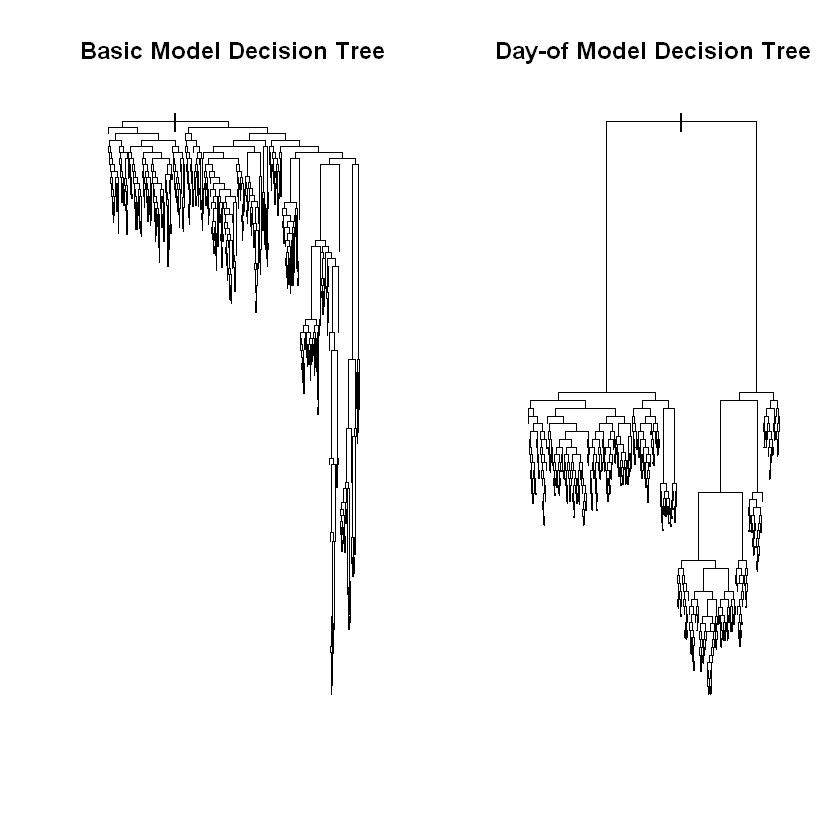

In [10]:
### Plot the structure of the models' decision trees
par(mfrow=c(1,2))
plot(basic, main="Basic Model Decision Tree")
plot(dayof, main="Day-of Model Decision Tree")


It looks like the Basic Model has many variables with similar levels of importance, while the Day-Of Model has a single variable that impacts the decision much more than the rest. We can see what this variable is by plotting variable importance for both models.

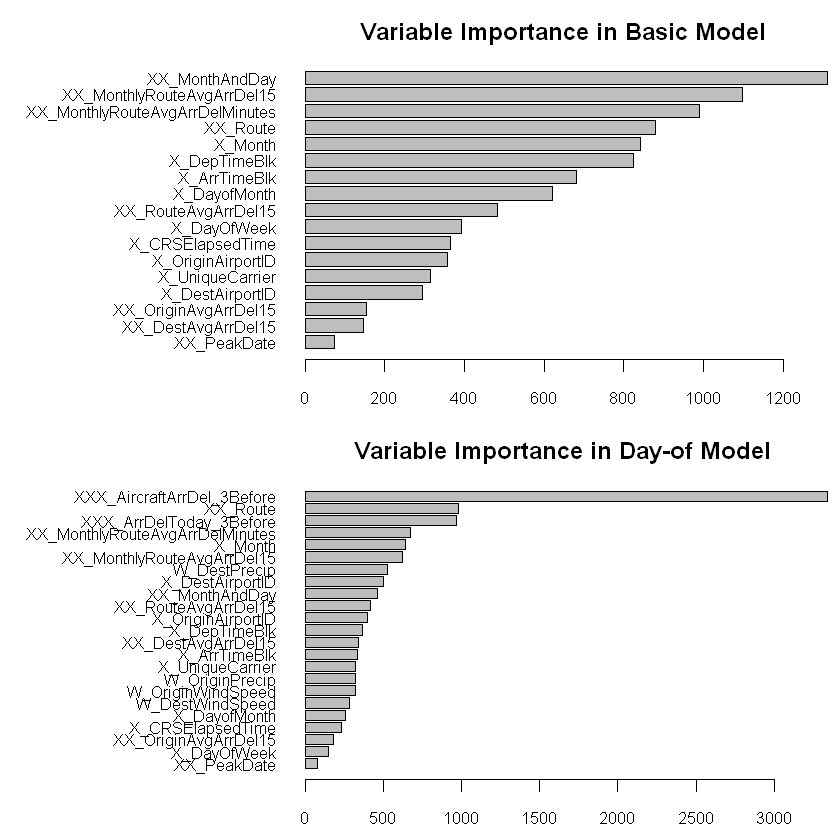

In [11]:
###Examine Variable Importance
par(mai=c(.5,2.5,.5,.1), mfrow=c(2,1))
barplot(sort(basic$variable.importance),main="Variable Importance in Basic Model", horiz=TRUE,las=1, cex.names = .8, cex.axis = .8)
barplot(sort(dayof$variable.importance),main="Variable Importance in Day-of Model", horiz=TRUE,las=1, cex.names = .8, cex.axis = .8)


That single variable causing the major split in the Day-Of decision tree was **AircraftArrDel_3Before**, a binary variable describing whether the flight's assigned aircraft was delayed for its most recent arrival or departure, as of three hours before the flight.  This makes a lot of sense, since a plane that's running late for an earlier flight is likely to continue running behind schedule. We can only use this in the Day-Of Model, of course, not the Basic Model, because this information only becomes available once the plane is actually on the go that day.

Now we'll evaluate the models using the function defined earlier 

In [12]:
###Evaluate Basic Model
cat("\nBasic Model \n")
basic_results = evaluateModel(basic, basicvars, train_indices, test_indices, vocal = TRUE)
basic_results

###Evaluate Day-Of Model
cat("\nDay-Of Model \n")
dayof_results = evaluateModel(dayof, dayofvars, train_indices, test_indices, vocal = TRUE)
dayof_results

###Check average delay level
cat("\n Average delay level across all flights:", mean(basicvars$Y_ArrDel15))


Basic Model 
_________________________________________________

Number of Flights

     Risk Level
Delay A_Low B_Medium C_High D_VeryHigh
    0 10147    10309   1733         99
    1  1168     2534   1197        284
_________________________________________________

Percent of Total Flights

     Risk Level
Delay A_Low B_Medium C_High D_VeryHigh
    0  36.9     37.5    6.3        0.4
    1   4.3      9.2    4.4        1.0
_________________________________________________


,A_del,B_del,C_del,D_del,A_sensitivity,C_sensitivity,D_sensitivity,Meaningful_preds
basic,0.1032,0.1973,0.4085,0.7415,0.4553,0.2309,0.0548,0.5325



Day-Of Model 
_________________________________________________

Number of Flights

     Risk Level
Delay A_Low B_Medium C_High D_VeryHigh
    0 15161     5429   1529        272
    1  1672     1326   1359        723
_________________________________________________

Percent of Total Flights

     Risk Level
Delay A_Low B_Medium C_High D_VeryHigh
    0  55.2     19.8    5.6        1.0
    1   6.1      4.8    4.9        2.6
_________________________________________________


,A_del,B_del,C_del,D_del,A_sensitivity,C_sensitivity,D_sensitivity,Meaningful_preds
dayof,0.0993,0.1963,0.4706,0.7266,0.6771,0.2675,0.1423,0.7541



 Average delay level across all flights: 0.1863619

**Prerequisite**<br> 
In the results tables, the first four measures describe the proportion of flights in each level that were delayed. This allows us to check if our prerequisite is fulfilled. We can see that it is successfully fulfilled for both models, as the delays levels are in fact approximately half the average for A, average for B, over twice the average for C, and over three times the average for D.

In other words, if you take a flight in the "Very High" risk level, you really do have a very high risk of being delayed: over 70% for both models! And so on for each level.

**Level Sensitivities**<br>
The next three measures tell us how sensitive the models are when it comes to flagging on-time flights as low risk and delayed flights as high or very high risk. The two models had similar C_sensitivity scores (high risk), but the Day-Of model was much better at identifying low risk and very high risk flights.

**Meaningful Predictions**<br>
The last measure in each results tables reports our most important success metric, meaningful predictions. For the Basic and Day-Of models above, the respective values are ~53% and ~75%.

This means that when using the Basic Model to book flights, travellers will have a good estimate of risk for about half the flights available to them, while the other half remain a mystery. This is pretty good, since the users don't really need to know the risk level of every single flight. They just need to book one, and it should be easy to choose one with a known risk level if half of all available flights have meaningful predictions.

As for the Day-of Model, travelers on three fourths of flights will have a good idea of how likely their flight is to be delayed.  This number could actually be even higher, however, if we assume that earlier the traveller used the Basic Model to help book their flight, and chose one that the Basic Model was able to give a prediction for.

# Cross-Validating the Models

To make sure that the results from the above models weren't just a fluke, let's run the cross validation function to find, on average, how much higher the level of meaningful predictions is for the Day-Of Model than the Basic Model. 

In [13]:
###Cross Validate
cat("\nBasic Model \n")
basic_crossval = crossVal(basicvars,5)
basic_crossval

cat("\nDay-Of Model \n")
dayof_crossval = crossVal(dayofvars,5)
dayof_crossval



Basic Model 

Fold 1 meaningful predictions:  0.5073 
Fold 2 meaningful predictions:  0.5341 
Fold 3 meaningful predictions:  0.4995 
Fold 4 meaningful predictions:  0.4987 
Fold 5 meaningful predictions:  0.5293 


,A_del,B_del,C_del,D_del,A_sensitivity,C_sensitivity,D_sensitivity,Meaningful_preds
Average,0.1010,0.1918,0.4027,0.7251,0.4340,0.2294,0.0575,0.5138
St. Dev,0.0033,0.0063,0.0024,0.0242,0.0191,0.0058,0.0056,0.0168



Day-Of Model 

Fold 1 meaningful predictions:  0.7038 
Fold 2 meaningful predictions:  0.6646 
Fold 3 meaningful predictions:  0.7234 
Fold 4 meaningful predictions:  0.7357 
Fold 5 meaningful predictions:  0.6979 


,A_del,B_del,C_del,D_del,A_sensitivity,C_sensitivity,D_sensitivity,Meaningful_preds
Average,0.0979,0.1911,0.4665,0.7131,0.6298,0.2358,0.1639,0.7051
St. Dev,0.0016,0.0076,0.0077,0.0171,0.0263,0.0133,0.0057,0.0272


Looking at the standard devations of the measures, we can get a sense of the models' variance. For some modeling situations, it might be worth putting a lot of effort to reduce variance, potentially turning to slower models such as random forests. In our case, however, Airbnb employees will likely be more positively impacted by the efficiency of a quick model, rather than the consistancy of a slower, low-variance one.


As a final step of analysis, let's look at the the two models' average results from cross-validation, side by side.

In [14]:
###Compare
comparison = rbind(basic_crossval[1,],dayof_crossval[1,]) 
rownames(comparison) = c("Basic", "Day-Of")
comparison

,A_del,B_del,C_del,D_del,A_sensitivity,C_sensitivity,D_sensitivity,Meaningful_preds
Basic,0.1010,0.1918,0.4027,0.7251,0.4340,0.2294,0.0575,0.5138
Day-Of,0.0979,0.1911,0.4665,0.7131,0.6298,0.2358,0.1639,0.7051


On average, both models provide value to users, with the Day-Of Model showing major increases in Level A sensitivity, Level D sensitivity. In terms of meaningful predictions, the Day-Of Model's level is about 20 percentage points higher than the Basic Model.

# Further Improvements

Following a "done is better than perfect" mentality, I decided to wrap up the project here, despite having a lot of ideas for further improvements and other things to try. A few things that I would implement if I were to continue spending time on this project would be:

- Pruning! I decided not to get into it at the moment because the results were already quite successful, and the standard pruning function hinges on traditional success measures, rather than my custom ones.<br><br>
- Train the model with data from more than the past 24 months. To keep the dataset a manageble size, I only downloaded data from April 2015 - March 2017.  This limited time span is probably the biggest limitation of my model, as is. <br><br>
- Try out feature selection and dimensionality reduction methods (e.g., PCA) that could lower run-time, making random forest or boosting methods more useable. <br><br>
- Incorporate *predicted* future weather conditions into the Basic Model.<br><br>
- Expand the dataset to include flights to and from more cities, or narrow it to just one origin, with many destinations, or vice versa. Or pick another tech company with multiple US offices, and build a model specifically for those cities. See how they compare to these ones.<br><br>
- Create a Day-Of Model with an "hours before flight" parameter, rather than a static three-hour setting. The eventual goal of a full-fledged tool would be real-time predictions.<br><br>
- Add an "Acceptable Delay" parameter to the models. Perhaps a traveller is fine with a 15 minute delay, but anything more than 30 minutes is unacceptable. Adding this parameter would require using the ArrDelMin (minutes delayed) variable from the original dataset to create a new Y variable based on the parameter, rather than using the current 15-minute one, precalculated by the DOT.

